# Web scraper to extract intial specifications and product links

## DRAFT - currently under development

### Important Details:
Website: https://www.appliancesonline.com.au/

# IMPORT MODULES

In [1]:
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import StaleElementReferenceException

from IPython.display import display

import time
from time import sleep
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import os, pickle

import session_info
session_info.show()

# HELPER FUNCTIONS

In [2]:
def get_element(element, element_tag: str, element_type: str):
    '''
    Functionality:
    ---------------------------------------------------------------------
    To simplify the process of finding and retrieving the value of 
    an element within an HTML file.
    
    ---------------------------------------------------------------------
    
    Parameters:
    ---------------------------------------------------------------------
    element      :  a selenium.webdriver element
    element_tag  :  the tag to search
    element_type : 'css_selector', 'container' or 'href' 
    
                    css_selector - retrieves the text of the element
                    container - retrieves the selected element
                    href - retrieves a link
    ---------------------------------------------------------------------
    
    Returns:
    ---------------------------------------------------------------------
    result : the value of the element or the element itself (if it exists),
             depending on the element_type selected.
    
    ---------------------------------------------------------------------
    '''
    
    result = None
    try:
        if(element_type == 'css_selector'):
            result = element.find_element_by_css_selector(element_tag).text
        
        elif (element_type == 'container'):
            result = element.find_element_by_css_selector(element_tag)
            
        elif (element_type == 'href'):
            result = element.find_element_by_class_name(element_tag).get_attribute('href')
            
    except NoSuchElementException:
        result = None
    except AttributeError:
        result = None
    
    return(result)   

In [3]:
def get_product_data(driver, data_dict: dict):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Simplification of data extraction from product pages.
    ---------------------------------------------------------------------
    
    
    Parameters:
    ---------------------------------------------------------------------
    driver      : a selenium.webdriver element
    data_dict   : the dictionary to store the data
    ---------------------------------------------------------------------
    
    
    User defined function calls:
    ---------------------------------------------------------------------
    get_element() : to retrieve data from a specific element
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    data_dict : a dictionary that contains the product data from that page
    including : ID, Product Name, Product Link, Price, Review Count,
    Review Score and Original Price.
    
    ---------------------------------------------------------------------
    '''
    Cells = driver.find_elements_by_css_selector('aol-product[trackinglistname="grid"] div.inner')
    offset = len(data_dict)
    for i, cell in enumerate(Cells):
            
        # Convert data to a dictionary
        data_dict[i+offset] = {"ID": str(i+offset).zfill(5),
                               "Product_Name": get_element(cell, 'div.product-name', 'css_selector'),                                                     
                               "Product_Link": get_element(cell, 'body-link', 'href'),
                               "Price": get_element(cell, 'div.price', 'css_selector'),
                               "Review_Count": get_element(cell, 'span.label', 'css_selector'),
                               "Review_Score": get_element(cell, 'span.avg-rating', 'css_selector'),
                               "Original_Price": get_element(cell, 'div.amount', 'css_selector')}

    return(data_dict)

In [4]:
def openPage(url_prefix: str, url_suffix: str, driver):
    '''
    Functionality:
    ---------------------------------------------------------------------
    To open a web page of interest and extract data from it.
    ---------------------------------------------------------------------
    
    
    Parameters:
    ---------------------------------------------------------------------
    url_prefix  : the prefix of the url to open
    url_suffix  : the suffix of the url to open
    driver: the selenium web driver used to open the pages
    ---------------------------------------------------------------------
    
    
    User defined function calls:
    ---------------------------------------------------------------------
    get_product_data() : to retrieve limited product data from a product summary page:
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    product_data : a dictionary that contains the product data from EVERY PAGE
    
    ---------------------------------------------------------------------
    '''
    product_data= {}
    
    # Page to load
    page_to_load = url_prefix + '1' + url_suffix
    
    # Load the web page
    driver.get(page_to_load)
    sleep(2)
    
    # Identify the number of products
    product_count = int(driver.find_element_by_css_selector('div.products-bar div.products-count').text.split(" ")[0])
    print(f'There were {product_count} products detected')
    
    #Get data from the first page 
    product_data = get_product_data(driver, data_dict = product_data)
    
    # Get data from the rest of the pages
    for i in range(2,int((product_count/24)+2)):
        sleep(2)
        page_to_load = url_prefix + str(i) + url_suffix
        driver.get(page_to_load)
        sleep(2)
        product_data = get_product_data(driver, data_dict = product_data)            
    return(product_data)


In [5]:
def save_DataFrame(df: pd.DataFrame, folder: str, filename: str, print_msg: bool = True):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Save a pandas dataframe to disk using the Pickle file format
    ---------------------------------------------------------------------
    
    
    Parameters:
    ---------------------------------------------------------------------
    df        : the dataframe to be saved to disk
    folder    : the folder that will hold the file to be saved
    filename  : the name of the file to be saved   
    print_msg : if True, then print the message that the file has been saved
    ---------------------------------------------------------------------
    '''
    try:
        # Set the path of the file
        current_directory = Path(".")
        filepath = os.path.join(current_directory, folder, filename)
        
        
        with open(filepath, 'wb') as handle:
            pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        if print_msg:
            print('')
            print(f'Dataframe has been saved to : //{folder}/{filename}')
        
    except:
        print(f'Problem saving the file: {filename} - Try again.')


In [6]:
# load_DataFrame : helper function     
def load_DataFrame(folder: str, filename: str, print_msg: bool = True):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Load a pandas dataframe from disk that was previously saved
    using the Pickle file format
    ---------------------------------------------------------------------
    
    
    Parameters:
    ---------------------------------------------------------------------
    folder    : the name of the folder to search for file (string)
    filename  : the name of the file to load  (string)
    print_msg : if True, then print the message that the file has been saved
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    df : the pandas dataframe that was previously saved to disk
    
    ---------------------------------------------------------------------
    '''
    df = None
    
    try:
        # Set the filepath
        current_directory = Path(".")
        filepath = os.path.join(current_directory, folder, filename)
        
        with open(filepath, 'rb') as handle:
            df = pickle.load(handle)
        
        if print_msg:
            print(f'Loaded: {filename}')
        
    except:
        print(f'Problem loading :{filename} : \n {filepath}')
        
    return(df)

In [7]:
def isNaN(num):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Checks if the 'num' value is NaN
    ---------------------------------------------------------------------
  
  
    Parameters:
    ---------------------------------------------------------------------
    num : the value to be checked
    ---------------------------------------------------------------------
    
    
    Returns:
    ---------------------------------------------------------------------
    True : if num is NaN
    False: if num is not NaN
    ---------------------------------------------------------------------
    '''
    
    return num != num


In [8]:
def get_Duration(start: float, stop: float, msg: str = 'Duration:'):
    '''
    Functionality:
    ---------------------------------------------------------------------
    Prints the time difference between start and stop times
    ---------------------------------------------------------------------
  
  
    Parameters:
    ---------------------------------------------------------------------
    start : a float representing when the timer was started
    stop  : a float representing when the timer was stopped
    msg   : a message to display before the time difference. eg.(Duration:)
    ---------------------------------------------------------------------
    
    Returns:
    ---------------------------------------------------------------------
    A string containing the message, and the duration in minutes and seconds
    ---------------------------------------------------------------------
    '''
    
    mins = str(int((stop - start) / 60)).zfill(2)
    secs = str(int((stop - start) % 60)).zfill(2)
    
    return(f'{msg}{mins}:{secs}')
            

# RETRIEVE INITIAL DATA

In [45]:
# Product page that lists the products
page_prefix = 'https://www.appliancesonline.com.au/filter/consumer-electronics/tvs/?currentpage='
page_suffix = '&sortkey=highestrated'  

# incognito mode
chrome_options = Options()
chrome_options.add_argument('--incognito')
driverPATH = 'C:\\University\\Master Class\\chromedriver_win32\\chromedriver.exe'
chrome_Browser = webdriver.Chrome(driverPATH, options=chrome_options)

# Start the timer
start_timer = time.perf_counter() 

# Get the product names and links and convert to a dataframe
product_dict = openPage(page_prefix, page_suffix, chrome_Browser)
product_df = pd.DataFrame(product_dict).T

# Stop the timer and display the time taken to download the data
stop_timer = time.perf_counter()
print(get_Duration(start_timer, stop_timer, 'Time taken to download data: '))

#Close the browser
chrome_Browser.quit()

# Save the product_df to disk in the 'Product' Folder
filename = input("SAVE FILENAME: Please enter the name of the file:")
save_DataFrame(df = product_df, folder='Product', filename=f'{filename}.pkl')


There were 147 products detected
Time taken to download data: 00:51


SAVE FILENAME: Please enter the name of the file: TV_names_and_links_df



Dataframe has been saved to : //Product/TV_names_and_links_df.pkl


# RETRIEVE DETAILED DATA 

In [64]:
# Load the previously saved product dataframe that contains the links required
product_df = load_DataFrame('Product', f'{filename}.pkl')

# Identify the number of products
n = len(product_df['Product_Link'])

# Dictionary to hold the download statistics
download_stats = {}

#Retrieve the data from every product web page -------------------------------------------------------------------------------------
for i in range(0, n):
    
    # Start timer for this round
    start_timer = time.perf_counter() 
    
    # SETUP -----------------------------------------------------------------------------
    
    # incognito mode
    chrome_options = Options()
    chrome_options.add_argument('--incognito')
    driverPATH = 'C:\\University\\Master Class\\chromedriver_win32\\chromedriver.exe'
    chrome_Browser = webdriver.Chrome(driverPATH, options=chrome_options)
    
    # Setup the variables to hold the data
    Overview = {}
    Specifications = {}
    Review_cage = []
    Reviews = {}
    page_to_load = product_df['Product_Link'][i]

    # Load the page and then maximise the window (must be maximised - limitation)
    chrome_Browser.get(page_to_load)
    sleep(2)
    chrome_Browser.maximize_window()
    sleep(5)
    
    page_source = chrome_Browser.page_source
    soup = BeautifulSoup(page_source, 'lxml')
    
    
    
    # OVERVIEW DATA  ----------------------------------------------------------------------
    if soup.find('div', class_='product-description') is not None:
        overview = soup.find('div', class_='product-description').text
    else:
        overview = None
   
    Overview[i] = {'ID': str(i).zfill(5),
                   'Overview' : overview}
    
    
    

    
    # DETAILED PRODUCT SPECIFICATIONS  --------------------------------------------------
    detailed_specs = {}
    detailed_specs['ID'] = str(i).zfill(5)
       
    for j in [1,2]:
        for k in range(1, 8):
            
            # Panel path split for readability
            panel_path = [f'#page-container > aol-product-page-container > aol-product-page > ul > li.grey.full.ng-star-inserted ',
                          f'> aol-product-page-content-middle > aol-product-navigation > div > aol-product-page-section:nth-child(4) ',
                          f'> section > div.section-content > aol-product-specifications > div > div:nth-child({j}) ', 
                          f'> aol-specifications-panel:nth-child({k}) > div > aol-product-specifications-attribute-row']
    
            p_path = panel_path[0] + panel_path[1] + panel_path[2] + panel_path[3]
            
            # Get all the rows in the panel
            rows = soup.select(p_path)
            
            # Skipping specific UNWANTED panels
            skip = False
            if (j<2 and k>6):
                skip = True
            
            # Extract the label and value for each row in the panel
            if not skip:
                for row in rows:
                    # EVERY row will have a label - no need to check
                    label = row.find('span', class_='attribute-name-text').text
                    
                    # There are three possible values, 1. normal text, 2.brand (link), 3. tick (svg image)
                    if row.find('div', class_= 'attribute-value') is not None:
                        value = row.find('div', class_= 'attribute-value').text
                    elif row.find('a', class_= 'attribute-value') is not None:
                        value = row.find('a', class_= 'attribute-value').text
                    else:
                        value = 'tick'

                    detailed_specs[label] = value
    

    

    # REVIEWS ----------------------------------------------------------------------------------
    # Get the number of reviews
    if isNaN(product_df['Review_Count'][i]):
        Review_count = 0
    elif product_df['Review_Count'][i] is None:
        Review_count = 0
    else:
        Review_count = int((product_df['Review_Count'][i]).split(" ")[1])
        
    stars = []
    if Review_count > 0:
        for j in range(2, 7):
            link = ['#page-container > aol-product-page-container > aol-product-page > ul > li.grey.full.ng-star-inserted ', 
                    '> aol-product-page-content-middle > aol-product-navigation > div > aol-product-page-section:nth-child(5) ',
                    '> section > div.section-content > aol-product-reviews > div > aol-reviews-summary > div ',
                    f'> div.summary.review.ng-star-inserted > div:nth-child({j}) > div.rating-number']
            star_link = link[0]+link[1]+link[2]+link[3]
            stars.append(soup.select(star_link)[0].text)
            
        counter = 1
        for star_count in stars[::-1]:
            detailed_specs[f'{counter}_star'] = int(star_count.replace(',',''))
            counter += 1
    
    
    
    # Save the detailed specifications into the Specifications dictionary
    Specifications[i] = detailed_specs
    


    # Check if the 'show more' button exists (needs more than 5 reviews)
    if get_element(chrome_Browser, 'wui-button.ng-star-inserted button.primary', 'container') is not None:
        show_more = get_element(chrome_Browser, 'wui-button.ng-star-inserted button.primary', 'container') 
    
        # Display the HIDDEN reviews by clicking the 'show more' button as many times as necessary
        for j in range(1,Review_count,5):
            
            # Javascript button needs a special method to work properly
            # As recommended by : https://stackoverflow.com/questions/48665001/can-not-click-on-a-element-elementclickinterceptedexception-in-splinter-selen
                
            try:
                chrome_Browser.execute_script("arguments[0].click();", show_more)     
            except StaleElementReferenceException:
                pass

    
    # A dictionary to store the reviews
    review_dict = {}
    
    # Set the new page source
    page_source = chrome_Browser.page_source
    soup = BeautifulSoup(page_source, 'lxml')
    
    # Check if the review panel exists
    if soup.select('aol-reviews-item.review') is not None:
        Review_panel = soup.select('aol-reviews-item.review')
        
        # START the Review timer
        rev_tic = time.perf_counter() 
        
        # Extract all the Reviews
        for j, review in enumerate(Review_panel):

            # Check for disclaimers
            disclaimer = review.find('div', class_='syndication')
            
            # If a disclaimer exists, then retrieve the message of where it was originally posted, 
            # and what size screen the post is about
            if disclaimer is not None:
                try:
                    orig_posted = disclaimer.find('span', class_= 'syndication-text').text
                except:
                    orig_posted = None
                
                try:
                    disclaimer_size = disclaimer.find('span', class_= 'syndication-text-label').text
                except:
                    disclaimer_size = None
                
            # Count the stars
            star_list = review.select('svg-icon.full-star.ng-star-inserted')
            star_count = len(star_list)

            # Do not include reviews for products that have a size disclaimer
            if disclaimer_size is None:
                review_dict[j] = {'ID': str(i).zfill(5),
                                  'Review_num' : str(j).zfill(5),
                                  'Review_star_count' : star_count,
                                  'Review_customer_name' : review.find('span', class_='name').text,
                                  'Review_date' : review.find('span', class_='date').text,
                                  'Review_title': review.find('div', class_='title').text,
                                  'Review_text': review.find('div', class_='text').text,
                                  'Review_originally_posted': orig_posted,
                                  'Review_disclaimer_size': disclaimer_size }

    # Save ALL of the product reviews (in review_dict) to 'Reviews'
    Reviews[i] = review_dict  
    
    
    # CLEAN UP ------------------------------------------------------------------------------------------------    
    
    # Close the browser
    chrome_Browser.quit()
    
    
    # Put data into dataframes and Save to disk
    Overview_df = pd.DataFrame(Overview[i],[i])
    Specifications_df = pd.DataFrame(Specifications[i],[i])
    Key_specs_df = pd.merge(Overview_df, Specifications_df, on='ID')
    Reviews_df = pd.DataFrame(Reviews[i]).T
    save_DataFrame(Reviews_df, 'Reviews', f'Reviews_{i}.pkl', print_msg=False)
    save_DataFrame(Key_specs_df, 'Key_specs', f'KeySpecs_{i}.pkl', print_msg=False)
    
    # Stop the timer for this round
    stop_timer = time.perf_counter() 
    download_stats[i] = {'Round': i,
                         'Reviews': len(review_dict),
                         'Group_total': Review_count,
                         'Scrape_time': get_Duration(start_timer, stop_timer, '') }
    
    
    # Show download progress
    if i%10 == 0:
        if i == 0 :
            print('.', end='')
        else:
            print(i, end='')
    else:
        print('.', end='')

        
# Show the downlaod stats 
print('\n\n')
download_stats_df = pd.DataFrame(download_stats).T  
download_stats_df = download_stats_df[['Round', 'Reviews', 'Group_total', 'Scrape_time']]
display(download_stats_df)

Loaded: TV_names_and_links_df.pkl
..........10.........20.........30.........40.........50.........60.........70.........80.........90.........100.........110.........120.........130.........140......




,Round,Reviews,Group_total,Scrape_time
0,0,298,1320,00:44
1,1,326,1320,00:44
2,2,314,1320,00:45
3,3,374,1320,00:45
4,4,550,1126,00:38
...,...,...,...,...
142,142,0,1,00:15
143,143,0,1,00:15
144,144,0,1,00:15
145,145,0,1,00:15


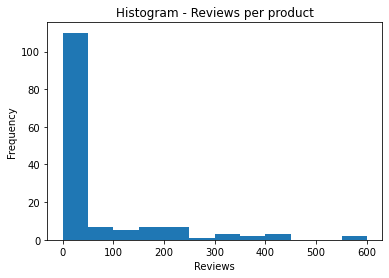

,Scrape_time,Reviews
count,147,
min,00:14,0.0
max,01:00,569.0
median,,4.0
mean,,60.1
std,,117.9


In [95]:
# Show the frequency distrubution of reviews per product
plt.hist(download_stats_df['Reviews'], range = (0,600), bins = 12)
plt.title('Histogram - Reviews per product')
plt.xlabel('Reviews')
plt.ylabel('Frequency')
plt.show()

download_stats_df.agg({"Scrape_time": ["count", "min", "max"],
                       "Reviews": ["min", "max", "median", "mean", "std"]}).round(1).fillna('')

# Combine the files to produce a single master dataframe

- The Key_specs_combined_df will be merged with the original_df based on 'ID'.
- The combined dataframe will be known as the 'master_df' which will be saved to disk for later processing.
- The master_df will not be visualised until **AFTER** it has been split into **Training and Testing sets** - to minimise and prevent data leakage.

In [12]:
key_specs_combined_df = None
current_directory = Path(".") #Get current directory
folder1 = 'Reviews'
folder2 = 'Key_specs'

# Identify the number of products
product_df = load_DataFrame('Product', f'TV_names_and_links_df.pkl')
n = len(product_df['Product_Link'])

merged_dataframes = {}

for i in range(0, n):
    file1 = f'Reviews_{i}.pkl'
    file2 = f'KeySpecs_{i}.pkl'
    
    # Load the review file
    Rev = load_DataFrame(folder1, file1, print_msg = False)
    
    # Reset the index of the dataframe. The review number captures the original index anyway (Review_num).
    Rev.reset_index(drop=True, inplace=True)
    
    # Identify the columns in the Review file (dataframe)
    Rev_columns = Rev.columns.to_list()

    # Identify the number of reviews in the Review file
    Rev_count = len(Rev.index)
    
    if Rev_count > 0:
        # Count the stars per review
        Rev_1_star = len(Rev[Rev['Review_star_count'] == 1])
        Rev_2_star = len(Rev[Rev['Review_star_count'] == 2])
        Rev_3_star = len(Rev[Rev['Review_star_count'] == 3])
        Rev_4_star = len(Rev[Rev['Review_star_count'] == 4])
        Rev_5_star = len(Rev[Rev['Review_star_count'] == 5])
        Rev_avg_star = ((1 * Rev_1_star) + (2 * Rev_2_star) + (3 * Rev_3_star) + (4 * Rev_4_star) + (5 * Rev_5_star)) / Rev_count
    else:
        Rev_1_star = np.nan
        Rev_2_star = np.nan
        Rev_3_star = np.nan
        Rev_4_star = np.nan
        Rev_5_star = np.nan
        Rev_avg_star = np.nan

    # Flatten the Reviews to a single row (separated by a pipe '|')
    Rev_flat_dict = {}
    for col in Rev_columns:
        if col == "ID":
            Rev_flat_dict['ID'] = Rev['ID'][0]
            Rev_flat_dict['Review_flat_count'] = Rev_count
            Rev_flat_dict['Review_flat_1_star'] = Rev_1_star
            Rev_flat_dict['Review_flat_2_star'] = Rev_2_star
            Rev_flat_dict['Review_flat_3_star'] = Rev_3_star
            Rev_flat_dict['Review_flat_4_star'] = Rev_4_star
            Rev_flat_dict['Review_flat_5_star'] = Rev_5_star
            Rev_flat_dict['Review_flat_avg_star'] = round(Rev_avg_star, 2)
        else:
            Rev_flat_dict[col] = '<|>'.join([str(elem) for elem in Rev[col].tolist()]) 

    # Convert back to dataframe        
    Rev_flat_df = pd.DataFrame(Rev_flat_dict, index=[0])

    
    # Load the Key Specs file
    K_specs= load_DataFrame(folder2, file2, print_msg = False)

    # Merge the two dataframes by ID only if the product has reviews.
    if len(Rev_flat_df.columns) > 0 :
        merged_df = pd.merge(K_specs, Rev_flat_df, on='ID', how='outer') # Use ID as the common column
    else:
        merged_df = K_specs
    
    # Add this dataframe to the list
    merged_dataframes[i] = merged_df


# Combine all the rows to a single dataframe. Note that the columns for each dataframe may be slightly different depending on specifications mentioned
frames = list(merged_dataframes.values())
Key_specs_combined_df = pd.concat(frames)

# Load the original products dataframe
product_df = load_DataFrame('Product', 'TV_names_and_links_df.pkl', print_msg=False)

# Combine the original dataframe to the Key_specs_combined_df
master_df = pd.merge(product_df, Key_specs_combined_df, on="ID", how='outer')

# Save the master_df as a pickle file 
save_DataFrame(master_df, 'Product', 'Master_df.pkl', print_msg=True)

Loaded: TV_names_and_links_df.pkl

Dataframe has been saved to : //Product/Master_df.pkl
